<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDBBindAdvancedProteinEmbeddingWMorganFingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q scikit-learn pandas tqdm deepchem rdkit torch torch-geometric fair-esm biopython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.4 MB/s eta 0:00:00


In [61]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn.functional as F
from torch.nn import Linear, LeakyReLU, ReLU, Sequential, BatchNorm1d, Dropout, LayerNorm
import torch_geometric
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import deepchem as dc
import pandas as pd
import esm
import pickle
from Bio import PDB
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import copy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [3]:
# Load PDBBind dataset
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [38]:
def remove_invalid_molecules(dc_dataset, dataset_name):
    valid_entries = []
    removed = 0
    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
      ligand_path = X[0][0]
      ligand_mol = Chem.MolFromMolFile(str(ligand_path))

      if ligand_mol is None:
        if str(dataset_name) == "train":
          removed += 1
        elif str(dataset_name) == "valid":
          removed += 1
        elif str(dataset_name) == "test":
          removed += 1
        continue

      valid_entries.append((X, y, w, ids))

    return valid_entries, removed

clean_train_dataset, train_removed = remove_invalid_molecules(train_dataset, "train")
clean_valid_dataset, valid_removed = remove_invalid_molecules(valid_dataset, "valid")
clean_test_dataset, test_removed = remove_invalid_molecules(test_dataset, "test")

print(f"New train dataset length: {len(clean_train_dataset)}. Removed molecules: {train_removed}\nNew validate dataset length: {len(clean_valid_dataset)}. Removed molecules: {valid_removed}\nNew test dataset length: {len(clean_test_dataset)}. Removed molecules: {test_removed}")

New train dataset length: 2235. Removed molecules: 1646
New validate dataset length: 280. Removed molecules: 205
New test dataset length: 272. Removed molecules: 214


In [39]:
def get_all_protein_lengths(dataset):
  parser = PDB.PDBParser(QUIET=True)
  molecule_protein_lengths = []
  for X, y, w, ids in dataset:
    protein_path = X[0][1]
    structure = parser.get_structure("protein", protein_path)
    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
        length = len(str(sequence))
    molecule_protein_lengths.append(length)

  return molecule_protein_lengths

def get_all_ligand_lengths(dataset):
  molecule_ligand_lengths = []
  for X, y, w, ids in dataset:
    ligand_path = X[0][0]
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    ligand_smiles = Chem.MolToSmiles(ligand_mol)
    length = len(str(ligand_smiles))
    molecule_ligand_lengths.append(length)

  return molecule_ligand_lengths

ligand_train_length_dataset = get_all_ligand_lengths(clean_train_dataset)
ligand_valid_length_dataset = get_all_ligand_lengths(clean_valid_dataset)
ligand_test_length_dataset = get_all_ligand_lengths(clean_test_dataset)
protein_train_length_dataset = get_all_protein_lengths(clean_train_dataset)
protein_valid_length_dataset = get_all_protein_lengths(clean_valid_dataset)
protein_test_length_dataset = get_all_protein_lengths(clean_test_dataset)

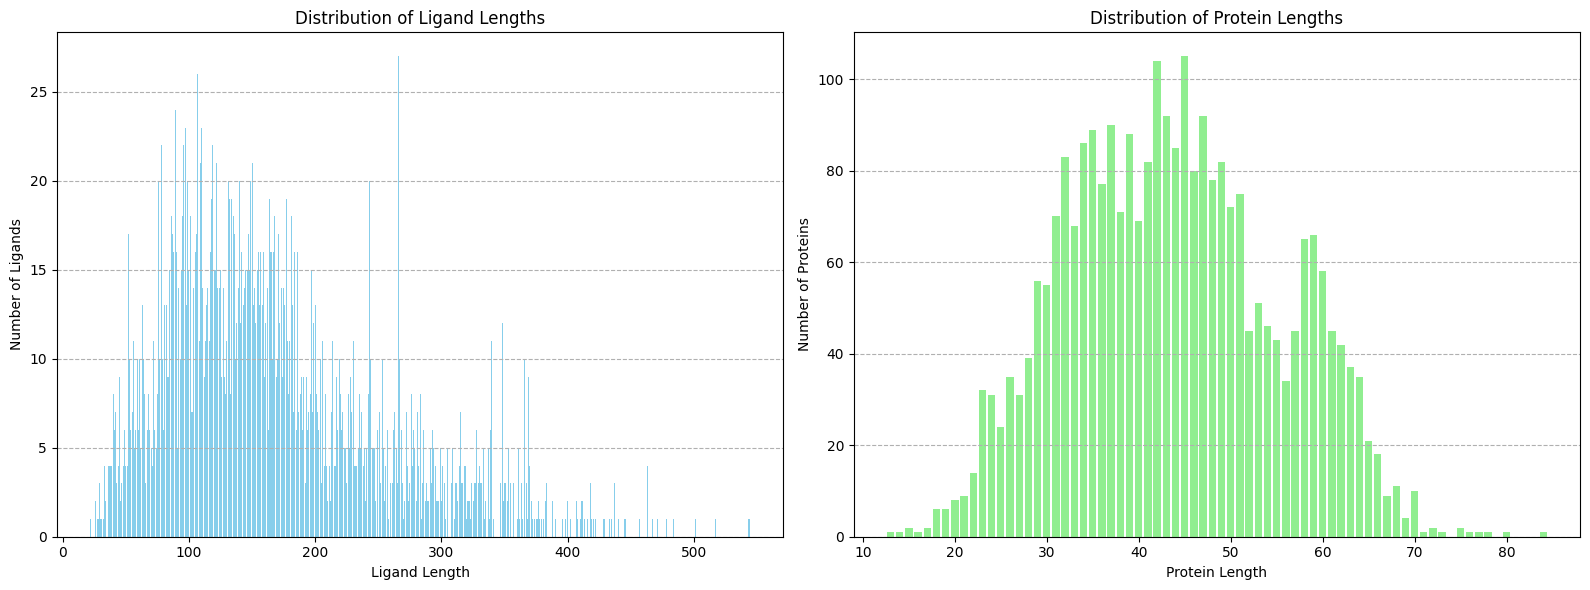

Max ligand length: 544
90% of ligands are shorter than or equal to: 294
Max protein length: 84
90% of proteins are shorter than or equal to: 60


In [41]:
## Combine all ligand lengths
all_ligand_lengths = ligand_train_length_dataset + ligand_valid_length_dataset + ligand_test_length_dataset
ligand_length_counts = Counter(all_ligand_lengths)
ligand_lengths = sorted(ligand_length_counts.keys())
ligand_counts = [ligand_length_counts[length] for length in ligand_lengths]

## Combine all protein lengths
all_protein_lengths = protein_train_length_dataset + protein_valid_length_dataset + protein_test_length_dataset
protein_length_counts = Counter(all_protein_lengths)
protein_lengths = sorted(protein_length_counts.keys())
protein_counts = [protein_length_counts[length] for length in protein_lengths]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

## Ligand plot
axs[0].bar(ligand_lengths, ligand_counts, color='skyblue')
axs[0].set_xlabel('Ligand Length')
axs[0].set_ylabel('Number of Ligands')
axs[0].set_title('Distribution of Ligand Lengths')
axs[0].grid(axis='y', linestyle='--')

## Protein plot
axs[1].bar(protein_lengths, protein_counts, color='lightgreen')
axs[1].set_xlabel('Protein Length')
axs[1].set_ylabel('Number of Proteins')
axs[1].set_title('Distribution of Protein Lengths')
axs[1].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

## Stats for ligand
max_ligand = max(all_ligand_lengths)
ligand_cutoff = int(np.percentile(all_ligand_lengths, 90))
print(f"Max ligand length: {max_ligand}")
print(f"90% of ligands are shorter than or equal to: {ligand_cutoff}")

## Stats for protein
max_protein = max(all_protein_lengths)
protein_cutoff = int(np.percentile(all_protein_lengths, 90))
print(f"Max protein length: {max_protein}")
print(f"90% of proteins are shorter than or equal to: {protein_cutoff}")

In [45]:
# Grab some random sample to show
for X, y, w, ids in clean_train_dataset:
    print("Features (X):", X)
    print("Label (y):", y)
    print("Weight (w):", w)
    print("ID:", ids)
    break

Features (X): [['/tmp/refined-set/4w9k/4w9k_ligand.sdf'
  '/tmp/refined-set/4w9k/4w9k_pocket.pdb']]
Label (y): [0.05771049]
Weight (w): [1.]
ID: ['4w9k']


**Preprocessing Functions**

Drug Preprocessing Functions

In [46]:
def get_node_features(mol):
  """
  Retrieve node features using RDKit
  """
  all_node_feats = []
  for atom in mol.GetAtoms():
      node_feats = [
          atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetFormalCharge(),
          int(atom.GetHybridization()),
          atom.GetIsAromatic(),
          atom.GetTotalNumHs(),
          atom.GetNumRadicalElectrons(),
          atom.IsInRing(),
          int(atom.GetChiralTag())
      ]
      all_node_feats.append(node_feats)
  return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
  """
  Retrieve edge features using RDKit
  """
  all_edge_feats = []
  for bond in mol.GetBonds():
      edge_feats = [
          bond.GetBondTypeAsDouble(),
          bond.IsInRing()
      ]
      all_edge_feats += [edge_feats, edge_feats]
  return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
  """
  Retrieve adjacency info using RDKit
  """
  edge_indices = []
  for bond in mol.GetBonds():
      i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
      edge_indices += [[i, j], [j, i]]
  return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

def get_morgan_fingerprint(mol, radius=2, n_bits=1024):
  """
  Generate Morgan fingerprint (ECFP) for a molecule.
  """
  if mol is None:
      return torch.zeros(n_bits, dtype=torch.float32)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
  return torch.tensor(list(fp), dtype=torch.float32)

Protein Preprocessing Functions

In [47]:
def extract_sequence_from_pdb(pdb_path):
  """
  Extracts the amino acid sequence from the associated protein PDB file using Biopython.
  """
  # Replace 'pocket' with 'protein' in the provided path
  protein_path = pdb_path.replace("pocket", "protein")

  parser = PDB.PDBParser(QUIET=True)
  structure = parser.get_structure("full_protein", protein_path)

  ppb = PDB.PPBuilder()
  sequence = ""
  for pp in ppb.build_peptides(structure):
      sequence += str(pp.get_sequence())

  return sequence

def extract_pocket_from_pdb(pdb_path):
  """
  Extracts the amino pocket amino acid sequence from a PDB file using Biopython
  """
  parser = PDB.PDBParser(QUIET=True)
  structure = parser.get_structure("pocket_only", pdb_path)

  ppb = PDB.PPBuilder()
  sequence = ""
  for pp in ppb.build_peptides(structure):
      sequence += str(pp.get_sequence())

  return sequence

# Load ESM-2 pretrained model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # loads ESM-2 model, defines how amino acids are tokenized
batch_converter = alphabet.get_batch_converter() # creates a function to convert sequences into tokenized tensors
model.eval()  # Disable dropout, puts the model in evaluation mode

def embed_sequence(seq):
  """
  Embed protein sequence using ESM-2
  """
  batch_labels, batch_strs, batch_tokens = batch_converter([("protein", seq)])
  with torch.no_grad():
      results = model(batch_tokens, repr_layers=[6], return_contacts=False)
  # Use mean over all residues (excluding padding and BOS/EOS)
  token_representations = results["representations"][6]
  embedding = token_representations[0, 1:len(seq)+1].mean(0) # outputs a single vector representing the whole protein using pretrained 33rd final layer
  return embedding  # shape: (320,) - 1D tensor with 1280 values, one for each learned feature in final transformer layer

def generate_combined_protein_embedding(pdb_path):
  """
  Complete protein embedding function that embeds both protein and protein pocket and combines together for final embedding
  """
  full_seq = extract_sequence_from_pdb(pdb_path)
  pocket_seq = extract_pocket_from_pdb(pdb_path)

  full_emb = embed_sequence(full_seq)
  pocket_emb = embed_sequence(pocket_seq)

  combined = torch.cat([full_emb, pocket_emb], dim=0)  # shape: (640,)

  return combined

In [48]:
# Test combined protein embeddings on a sample pdb file
example_protein_path = "/tmp/refined-set/5fnu/5fnu_pocket.pdb"

combined = generate_combined_protein_embedding(example_protein_path)
print(combined.shape)

torch.Size([640])


**Preprocessing the Data Sets**

In [51]:
def process_deepchem_dataset(dataset):
    molecule_data = []

    for X, y, w, ids in tqdm(dataset):
        ligand_path = X[0][0]
        protein_path = X[0][1]

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))
        if ligand_mol is None:
            continue

        # --- Atom & bond graph features ---
        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)

        # --- Morgan fingerprint features ---
        smiles = Chem.MolToSmiles(ligand_mol)
        morgan_fp = get_morgan_fingerprint(ligand_mol, radius=2, n_bits=1024)


        # --- Protein embeddings ---
        target_features = generate_combined_protein_embedding(protein_path)
        target_features = target_features.unsqueeze(0)  # (1, 640)

        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features
        data.morgan_fp = morgan_fp.unsqueeze(0)

        molecule_data.append(data)

    return molecule_data


In [53]:
# Build data graphs and dataloaders
train_graphs = process_deepchem_dataset(clean_train_dataset)
valid_graphs = process_deepchem_dataset(clean_valid_dataset)
test_graphs = process_deepchem_dataset(clean_test_dataset)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

100%|██████████| 272/272 [02:01<00:00,  2.24it/s]


In [57]:
# Save processed data to pkl files
processed_data = {
    "train": train_graphs,
    "valid": valid_graphs,
    "test": test_graphs,
}

with open("processed_datasets.pkl", "wb") as f:
    pickle.dump(processed_data, f)

print("Saved preprocessed datasets to processed_datasets.pkl")

Saved preprocessed datasets to processed_datasets.pkl


In [58]:
# Use pickle file to load data
with open("/content/processed_datasets.pkl", "rb") as f:
    data = pickle.load(f)

train_graphs = data["train"]
valid_graphs = data["valid"]
test_graphs = data["test"]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

**Training Algorithm**

In [59]:
class GINModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, protein_dim=640, fp_dim=1024, hidden_dim=128, output_dim=1, dropout=0.2):
        # Super init to initialize parent (torch.nn.module)
        super(GINModel, self).__init__()

        # Node features multi-layer perceptron with layer normalizatoin, ReLU, and dropout between layers
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            LayerNorm(hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Two GIN layers for better molecular representation
        nn1 = Sequential(
            Linear(hidden_dim, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)

        nn2 = Sequential(
            Linear(hidden_dim, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)


        # Proteins sequential encoder
        self.pocket_embedding = Sequential(
            Linear(protein_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Morgan fingerprint sequential encoder
        self.fp_embedding = Sequential(
            Linear(fp_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Attention encoder
        self.attention = Sequential(
            # Takes in combined features of morgan fingerprints, proteins, and node features, which after encoding have size -> hidden_dim, so total is 3 * hidden_dim
            Linear(3 * hidden_dim, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            # Outputs linear layer with weight of each modality encoding
            Linear(hidden_dim, 3),
            torch.nn.Softmax(dim=1)
        )

        # Fusion predictor of 3 modalities
        self.predictor = Sequential(
            Linear(3 * hidden_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim // 2),
            LeakyReLU(negative_slope=0.01),
            Dropout(dropout * 0.5),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        x = self.node_embedding(batch.x)

        x1 = F.relu(self.conv1(x, batch.edge_index))
        x1 = self.bn1(x1)

        x2 = F.relu(self.conv2(x1, batch.edge_index))
        x2 = self.bn2(x2)
        x2 = x2 + x1  # Residual connection

        # Use both sum and mean pooling for molecule embedding
        mol_emb = (global_add_pool(x2, batch.batch) + global_mean_pool(x2, batch.batch)) / 2

        # Protein embedding
        pocket_emb = self.pocket_embedding(batch.target_features.float())

        # Morgan fingerprint embedding
        fp_emb = self.fp_embedding(batch.morgan_fp.float())

        # Attention-weighted fusion ---
        combined = torch.cat([mol_emb, pocket_emb, fp_emb], dim=1)
        attention_weights = self.attention(combined)

        # Stack embeddings and apply attention
        stacked = torch.stack([mol_emb, pocket_emb, fp_emb], dim=2)
        weighted = stacked * attention_weights.unsqueeze(1)
        attended = weighted.sum(dim=2)

        # Combine original and attended features
        final_features = torch.cat([combined, attended], dim=1)

        # Use residual connection in predictor
        result = self.predictor(combined)
        return result

In [10]:
def train_with_kfold(dataset, k_folds=5, num_epochs=200, patience=25, lr=0.001, device='cpu', batch_size=32):
    """
    Train model using K-Fold Cross-Validation
    """
    print(f"Using device: {device}")
    print(f"Starting {k_folds}-Fold Cross-Validation")

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_results = []

    # Convert dataset to list of indices
    indices = list(range(len(dataset)))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n{'='*50}")
        print(f"FOLD {fold + 1}/{k_folds}")
        print(f"{'='*50}")

        # Create data loaders for this fold
        from torch_geometric.loader import DataLoader
        train_subset = [dataset[i] for i in train_idx]
        val_subset = [dataset[i] for i in val_idx]

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize fresh model for this fold
        model = GINModel(node_feat_dim=9, protein_dim=640, fp_dim=1024)

        # Train the model
        trained_model, best_val_loss = train_single_fold(
            model, train_loader, val_loader,
            num_epochs=num_epochs, patience=patience,
            lr=lr, device=device, fold=fold+1
        )

        fold_results.append({
            'fold': fold + 1,
            'best_val_loss': best_val_loss,
            'model': trained_model
        })

    # Print summary
    print(f"\n{'='*50}")
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print(f"{'='*50}")
    val_losses = [r['best_val_loss'] for r in fold_results]
    print(f"Mean Validation Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
    for i, result in enumerate(fold_results):
        print(f"Fold {i+1}: {result['best_val_loss']:.4f}")

    # Return best model
    best_fold = min(fold_results, key=lambda x: x['best_val_loss'])
    print(f"\nBest model from Fold {best_fold['fold']} with loss {best_fold['best_val_loss']:.4f}")

    return best_fold['model'], fold_results

def train_single_fold(model, train_loader, val_loader, num_epochs=200, patience=25, lr=0.001, device='cpu', fold=1):
    """
    Train a single fold with enhanced techniques
    """
    model = model.to(device)

    # AdamW optimizer with weight decay for better generalization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Gradient clipping value
    max_grad_norm = 1.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)

            # MSE Loss
            loss = F.mse_loss(preds, targets)

            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)
                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        train_loss_avg = np.mean(train_losses)
        val_loss_avg = np.mean(val_losses)

        # Calculate additional metrics
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)
        mae = np.mean(np.abs(all_preds - all_targets))
        rmse = np.sqrt(val_loss_avg)

        # Update learning rate
        scheduler.step(val_loss_avg)

        # Early stopping and model checkpointing
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Print progress every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Fold {fold} - Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f} - "
                  f"MAE: {mae:.4f} - RMSE: {rmse:.4f} - LR: {current_lr:.6f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, best_val_loss

In [62]:
device='cuda' if torch.cuda.is_available() else 'cpu'

full_train_dataset = train_graphs + valid_graphs

model, fold_results = train_with_kfold(
  dataset=full_train_dataset,
  k_folds=5,
  num_epochs=100,
  patience=25,
  lr=0.0005,
  device=device,
  batch_size=32
)


Using device: cuda
Starting 5-Fold Cross-Validation

FOLD 1/5
Fold 1 - Epoch 1/100 - Train Loss: 0.9759 - Val Loss: 0.6630 - MAE: 0.6495 - RMSE: 0.8143 - LR: 0.000500
Fold 1 - Epoch 10/100 - Train Loss: 0.1640 - Val Loss: 0.5337 - MAE: 0.5681 - RMSE: 0.7305 - LR: 0.000500
Fold 1 - Epoch 20/100 - Train Loss: 0.1104 - Val Loss: 0.4810 - MAE: 0.5290 - RMSE: 0.6936 - LR: 0.000500
Fold 1 - Epoch 30/100 - Train Loss: 0.0750 - Val Loss: 0.4973 - MAE: 0.5333 - RMSE: 0.7052 - LR: 0.000500
Fold 1 - Epoch 40/100 - Train Loss: 0.0697 - Val Loss: 0.4817 - MAE: 0.5248 - RMSE: 0.6941 - LR: 0.000250
Fold 1 - Epoch 50/100 - Train Loss: 0.0541 - Val Loss: 0.4711 - MAE: 0.5158 - RMSE: 0.6864 - LR: 0.000250
Fold 1 - Epoch 60/100 - Train Loss: 0.0512 - Val Loss: 0.4847 - MAE: 0.5187 - RMSE: 0.6962 - LR: 0.000250
Fold 1 - Epoch 70/100 - Train Loss: 0.0451 - Val Loss: 0.4836 - MAE: 0.5195 - RMSE: 0.6954 - LR: 0.000125
Early stopping triggered at epoch 78

FOLD 2/5
Fold 2 - Epoch 1/100 - Train Loss: 0.9574 - 

**Performance Evaluation**

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    medae = median_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # MAPE (avoid division by zero)
    nonzero_idx = actuals != 0
    mape = mean_absolute_percentage_error(actuals[nonzero_idx], predictions[nonzero_idx]) if np.any(nonzero_idx) else np.nan

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Median AE: {medae:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")
    return mse, rmse, mae, medae, r2, mape

print("Evaluating on Test Set:")

test_mse, test_rmse, test_mae, test_median_ae, test_r2, test_mape = evaluate_model(model=model, loader=test_loader, device=device)

Evaluating on Test Set:
  MSE: 0.4962
  RMSE: 0.7044
  MAE: 0.5192
  Median AE: 0.3696
  R-squared: 0.5000
  MAPE: 2.6435


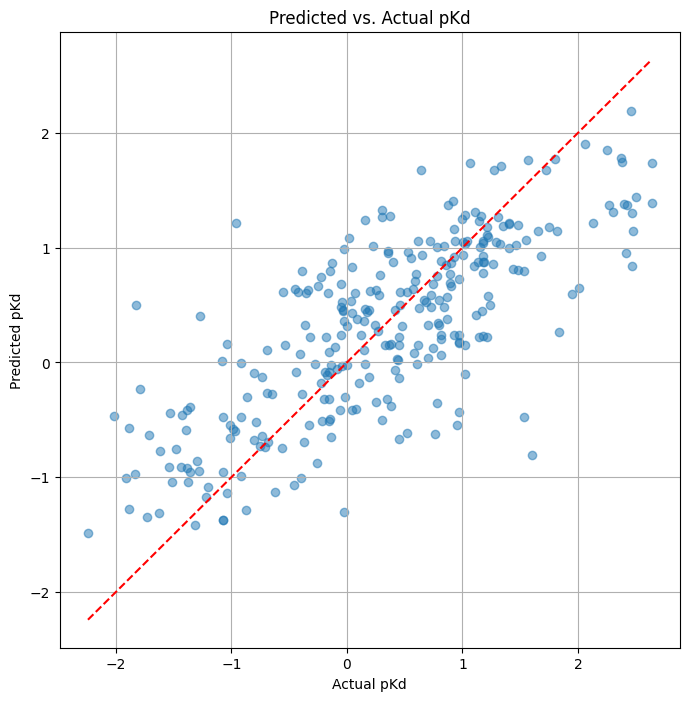

In [36]:
def plot_predictions_vs_actual(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(model, test_loader, device=device)